In [1]:
import os
import numpy as np
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Logistic Regression

In [2]:
df = pd.read_table('./ex2/ex2data1.txt', delimiter=',', names=['score1', 'score2', 'admit'])

df.head()

,score1,score2,admit
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### Visualize

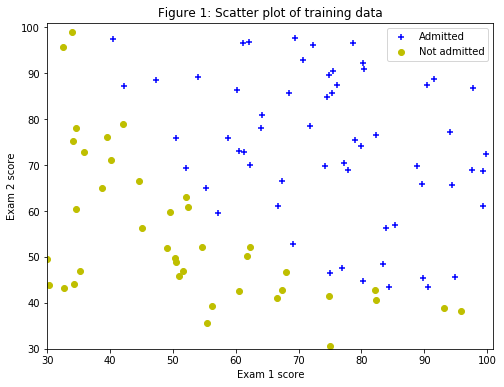

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(df[df['admit'] == 1]['score1'], df[df['admit'] == 1]['score2'], marker='+', color='b', label='Admitted')
plt.scatter(df[df['admit'] == 0]['score1'], df[df['admit'] == 0]['score2'], marker='o', color='y', label='Not admitted')
plt.title('Figure 1: Scatter plot of training data')
plt.xlim([30, 101])
plt.ylim([30, 101])
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(loc='upper right')
plt.show()

In [4]:
# set up
X = np.array(df[['score1', 'score2']])
X = np.hstack([np.ones([X.shape[0],1]), X])
y = np.array(df['admit'])
THETA = np.zeros(X.shape[1])

### Cost Function and Gradient

In [5]:
def sigmoid(x):
    if isinstance(x, list):
        x = np.array(x)
    return 1 / (1 + np.exp(-x))

In [6]:
def costFunction(theta, x, y):
    """x: (n, p+1)
       y: (n, )
       theta: (p+1, )
    """
    h = sigmoid(np.dot(x, theta))
    total_cost = np.multiply(y, np.log(h + 1e-8)) + np.multiply((1 - y), np.log(1 - h + 1e-8))
    cost = - np.mean(total_cost)
    return cost

In [7]:
print("Cost with initial theta: %.3f" % costFunction(THETA, X, y))

Cost with initial theta: 0.693


In [8]:
def gradientDescent(theta, x, y):
    h = sigmoid(np.dot(x, theta))
    return np.dot(x.T, h - y) / x.shape[0]

### Learn parameters using `scipy.optimize.minimize`

In [9]:
optim = minimize(costFunction, x0=THETA, jac=gradientDescent, args=(X, y), options={'disp': True, 'maxiter': 400})

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29


In [10]:
optim_THETA = optim.x
print("Optimal Theta:", optim_THETA)

Optimal Theta: [-25.16114281   0.2062303    0.20146993]


In [11]:
def predict(x, theta, return_prob=False):
    if isinstance(x, list):
        x = np.array(x)
    prob = sigmoid(np.dot(x, theta))
    if return_prob:
        return prob
    else:
        return (prob > 0.5).astype(int)

In [12]:
print("Predicted admission probability: %.3f" % predict([1, 45, 85], optim_THETA, return_prob=True))

Predicted admission probability: 0.776


In [13]:
print("Training Accuracy: %d%%" % (100 * np.mean(predict(X, optim_THETA, return_prob=False) == y)))

Training Accuracy: 89%


In [14]:
x1 = np.arange(30, 101)
y1 = (- optim_THETA[1] * x1 - optim_THETA[0])/optim_THETA[2]

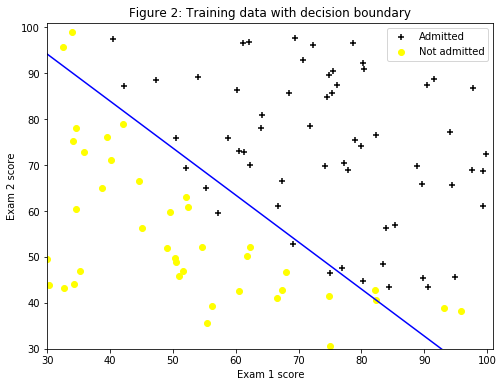

In [15]:
plt.figure(figsize=(8,6))
plt.scatter(df[df['admit'] == 1]['score1'], df[df['admit'] == 1]['score2'], marker='+', color='black', label='Admitted')
plt.scatter(df[df['admit'] == 0]['score1'], df[df['admit'] == 0]['score2'], marker='o', color='yellow', label='Not admitted')
plt.plot(x1, y1, 'b-')
plt.title('Figure 2: Training data with decision boundary')
plt.xlim([30, 101])
plt.ylim([30, 101])
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend(loc='upper right')
plt.show()

## Regularized Logistic Regression

In [16]:
df2 = pd.read_table('./ex2/ex2data2.txt', delimiter=',', names=['test1', 'test2', 'accept'])

df2.head()

,test1,test2,accept
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


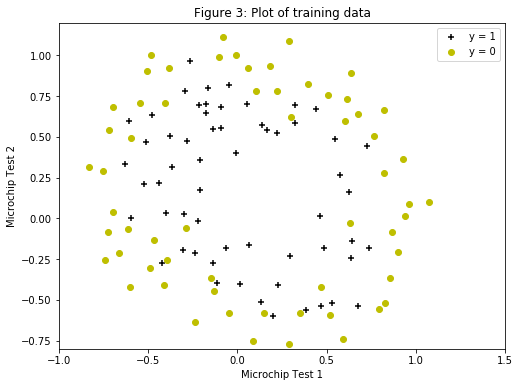

In [17]:
plt.figure(figsize=(8,6))
plt.scatter(df2[df2['accept'] == 1]['test1'], df2[df2['accept'] == 1]['test2'], marker='+', color='black', label='y = 1')
plt.scatter(df2[df2['accept'] == 0]['test1'], df2[df2['accept'] == 0]['test2'], marker='o', color='y', label='y = 0')
plt.title('Figure 3: Plot of training data')
plt.xlim([-1, 1.5])
plt.ylim([-0.8, 1.2])
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
plt.legend(loc='upper right')
plt.show()

In [18]:
def mapFeature(x, degree):
    x = np.array(x)
    x_poly = np.ones([x.shape[0], 1])
    for i in range(1, degree+1):
        for j in range(0, i+1):
            new_x = np.multiply((x[:,0] ** (i-j)), x[:,1] ** j).reshape([-1, 1])
            x_poly = np.hstack([x_poly, new_x])
    return x_poly

In [19]:
X = mapFeature(df2[['test1', 'test2']], 6)
y = np.array(df2['accept'])
THETA = np.zeros(X.shape[1])

In [20]:
def costFunctionReg(theta, x, y, alpha0):
    h = sigmoid(np.dot(x, theta))
    cost = -np.mean(np.multiply(y, np.log(h + 1e-8)) + np.multiply(1 - y, np.log(1 - h + 1e-8)))
    ridge_term = alpha0 * np.dot(theta[1:], theta[1:]) / (2 * len(y))
    cost += ridge_term
    return cost

In [21]:
def gradientDescentReg(theta, x, y, alpha0):
    h = sigmoid(np.dot(x, theta))
    grad = np.dot(x.T, h - y) / len(y)
    grad[1:] += alpha0 * theta[1:] / len(y)
    return grad

In [22]:
print("Cost with initial theta: %.3f" % costFunctionReg(THETA, X, y, 1))
print("Gradients with initial theta:")
print(["%.4f" % i for i in gradientDescentReg(THETA, X, y, 1)[:5]])

Cost with initial theta: 0.693
Gradients with initial theta:
['0.0085', '0.0188', '0.0001', '0.0503', '0.0115']


In [23]:
optimReg = minimize(costFunctionReg, x0=THETA, jac=gradientDescentReg, args=(X, y, 1), options={'disp': True, 'maxiter': 400})

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


In [24]:
def plotDecisionBoundary(alpha0=1, title=''):
    op = minimize(costFunctionReg, x0=THETA, jac=gradientDescentReg, args=(X, y, alpha0), options={'disp': True, 'maxiter': 400})
    optim_theta = op.x
    xx1, xx2 = np.meshgrid(np.arange(-1, 1.5, 0.02), np.arange(-0.8, 1.2, 0.02))
    xx = np.c_[xx1.ravel(), xx2.ravel()]

    Z = predict(mapFeature(xx, 6), optim_theta)
    Z = Z.reshape(xx1.shape)

    plt.figure(figsize=(8,6))
    s1 = plt.scatter(df2[df2['accept'] == 1]['test1'], df2[df2['accept'] == 1]['test2'], marker='+', color='black', label='y = 1')
    s2 = plt.scatter(df2[df2['accept'] == 0]['test1'], df2[df2['accept'] == 0]['test2'], marker='o', color='y', label='y = 0')
    c1 = plt.contour(xx1, xx2, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlim([-1, 1.5])
    plt.ylim([-0.8, 1.2])
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend(loc='upper right')
    plt.show()

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48


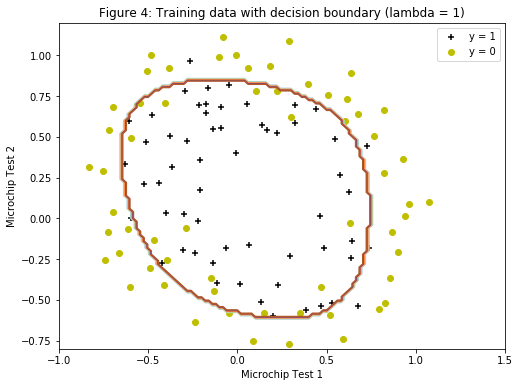

In [25]:
plotDecisionBoundary(1, 'Figure 4: Training data with decision boundary (lambda = 1)')

In [26]:
op = minimize(costFunctionReg, x0=THETA, jac=gradientDescentReg, args=(X, y, 0), options={'disp': True, 'maxiter': 400})
optim_theta = op.x
xx1, xx2 = np.meshgrid(np.arange(-1, 1.5, 0.02), np.arange(-0.8, 1.2, 0.02))
xx = np.c_[xx1.ravel(), xx2.ravel()]

         Current function value: 0.263499
         Iterations: 400
         Function evaluations: 401
         Gradient evaluations: 401


         Current function value: 0.263499
         Iterations: 400
         Function evaluations: 401
         Gradient evaluations: 401


C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


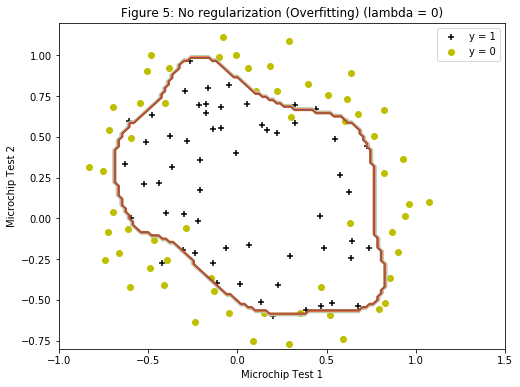

In [27]:
# warning due to exp(a large number) in sigmoid function
plotDecisionBoundary(0, 'Figure 5: No regularization (Overfitting) (lambda = 0)')

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


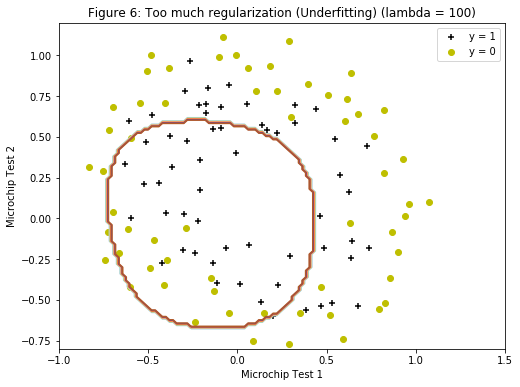

In [28]:
plotDecisionBoundary(100, 'Figure 6: Too much regularization (Underfitting) (lambda = 100)')